# Is the first album the best?

This one's pretty clear: I want to know if the first release by an artist tends to outshine future releases. Let's go!

In [1]:
import sqlite3, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from scipy.stats import ttest_rel

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

con = sqlite3.connect('../pitchfork.db')
scores = pd.read_sql('SELECT reviewid, score FROM reviews', con)
artists = pd.read_sql('SELECT * FROM artists', con)
years = pd.read_sql('SELECT * FROM years', con)
con.close()

# combine into score-artist mapping
reviews = pd.merge(scores, artists, on = 'reviewid')

# remove various artists
reviews = reviews[reviews.artist != 'various artists']

# remove multi-year reviews [re-releases]
year_counts = years.groupby('reviewid').count().reset_index()
keepers = year_counts.loc[year_counts.year == 1, 'reviewid']
reviews = reviews.loc[reviews.reviewid.isin(keepers)]

## Starting with some descriptives

The first thing to do is describe the distribution of number of reviews per artist, and how frequently-reviewed artists score relative to artists with just a couple reviews.

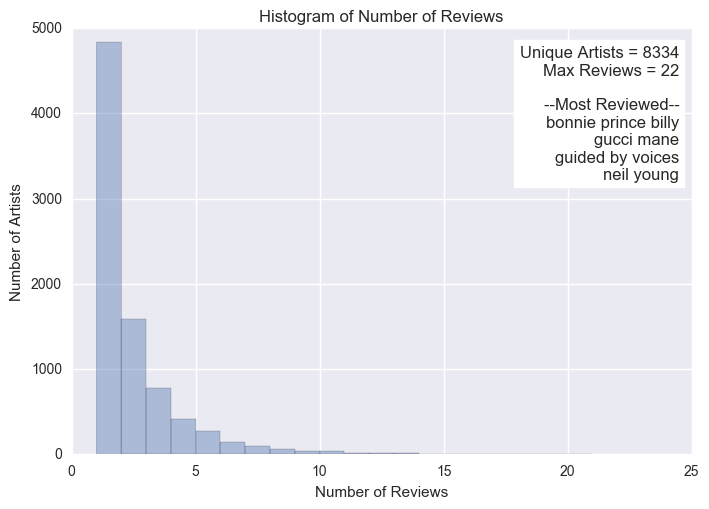

In [2]:
numreviews = reviews.groupby('artist').size()

num_artists = len(numreviews)
most_reviews = numreviews.max()
most_reviewed = numreviews[numreviews >= most_reviews-2].index.values

#plot histogram
sns.distplot(numreviews, range(1, numreviews.max()), kde = False)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Artists')


# create descriptive box
S = (
    "Unique Artists = " + str(num_artists) + '\n' + 
    "Max Reviews = " + str(most_reviews) + '\n\n' + 
    "--Most Reviewed--" 
    )

for i in most_reviewed:
    S+= '\n' + i

plt.text(24.5, 4800, S, backgroundcolor = 'w', va = 'top', ha = 'right')

plt.title('Histogram of Number of Reviews')
plt.show()

The majority of artists have only a single review, and the distribution from there declines exponentially. Do artists with just one review score any better or worse than others?

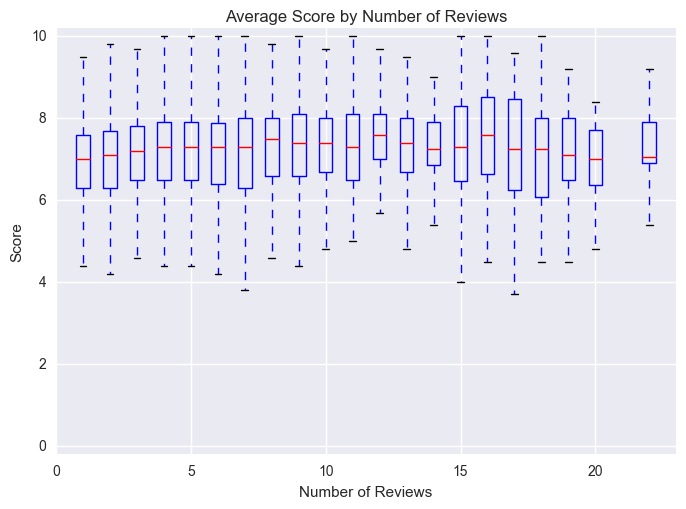

In [3]:
for x, rows in numreviews.groupby(numreviews):
    group_scores = reviews.loc[reviews.artist.isin(rows.index.values),'score']
    plt.boxplot(group_scores.as_matrix(), positions = [x], widths = 0.5,
               manage_xticks = False)
plt.xlim([0,23])
plt.ylim([-0.2,10.2])
plt.ylabel('Score')
plt.xlabel('Number of Reviews')
plt.title('Average Score by Number of Reviews')

plt.show()

It doesn't look like there is much in terms of differences in the scores for frequently versus infequently reviewed artists. That's already some evidence against the first album being the best, since you'd expect two-review artists to score a bit worse.

Anyway, from here I'm just going to look at the data for artists with more than one review.

## Do scores decline over releases?

In [4]:
# remove artists with less than 2 reviews
keep_artists = numreviews[numreviews > 1].index.values
twoplus = reviews.loc[reviews.artist.isin(keep_artists)]

# add review number per artist
twoplus = twoplus.assign(number = pd.Series(index=twoplus.index))
for a, rows in twoplus.groupby('artist'):
    values = list(reversed(range(rows.shape[0])))
    twoplus.set_value(rows.index, 'number', values)
    
twoplus['number'] = twoplus['number'].astype(int)

LinregressResult(slope=-0.0094435436907557239, intercept=7.0454277874218691, rvalue=-0.018255894710423479, pvalue=0.04390619477519711, stderr=0.0046861697646921495)


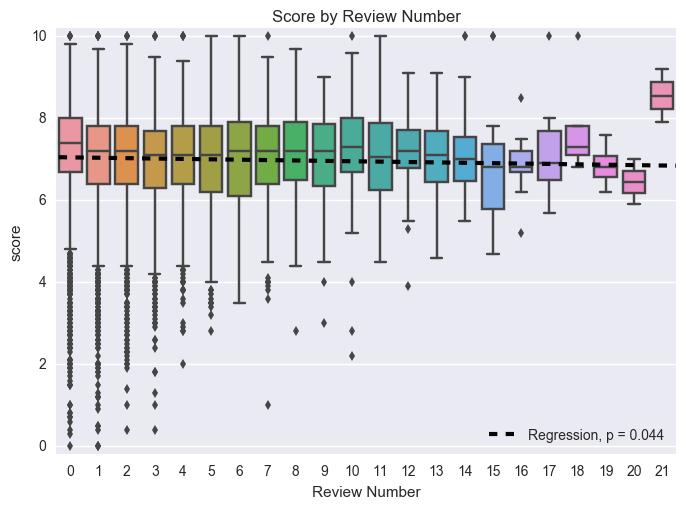

In [5]:
# plot boxes
sns.boxplot(x = 'number', y = 'score',  data = twoplus)

# add regression
reg = linregress(twoplus.number, twoplus.score)
print(reg)

x = np.arange(-1, 23)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))
plt.legend(loc = 'lower right')

plt.xlabel('Review Number')
plt.title('Score by Review Number')
plt.ylim([-0.2, 10.2])
plt.show()


### Results

It is *technically* true that scores decline over time, but that pattern is super super weak. I plotted the regression line, and while review number "significantly" predicts the score, it's not exactly impressive.

Really, it looks to me like the chances of getting a very low score (< 5) are greater for early reviews. It's possible that there are just more of these reviews, but that wouldn't explain more low *outliers*. My guess is that, following a very low score, Pitchfork is less likely to review future releases (or the artist is less likely to produce another album).

So the first album may not be the best one, **but maybe the last album is the worst.**

## Is the last album the worst?


In [6]:
finalsplit = twoplus.copy()

# add final release indicator
finalsplit = finalsplit.assign(final = pd.Series(index=finalsplit.index))
for a, rows in finalsplit.groupby('artist'):
    
    values = rows.number == max(rows.number)
    values[values == False] = 'Not Final'
    values[values == True ] = 'Final Release'
    finalsplit.set_value(rows.index, 'final', values)

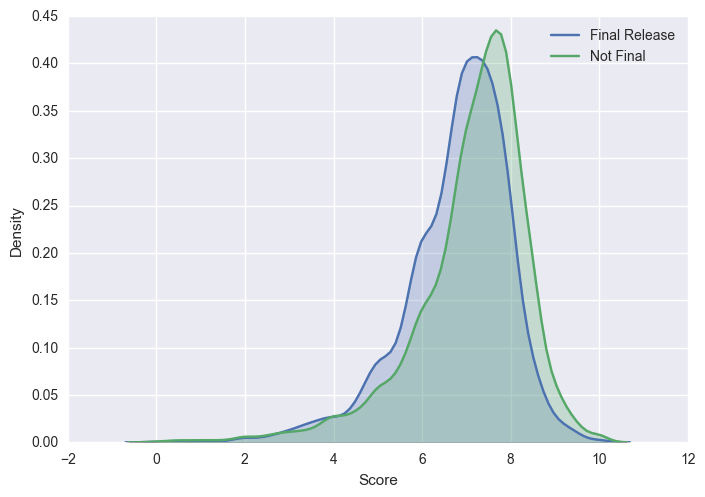

In [7]:
for i, rows in finalsplit.groupby('final'):
    sns.kdeplot(rows.score, shade = True, label = i)
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

In [8]:
groups = finalsplit.groupby(['final','artist'])
groups = groups['score'].agg('mean')

t = ttest_rel(groups['Not Final'], groups['Final Release'])
print('T Test, p = ' + str(t.pvalue) + '\n')

for i, rows in finalsplit.groupby('final'):
    S  = i + '\t' + 'M = ' + str(round(groups[i].mean(),4))
    S += '\tSD = ' + str(round(groups[i].std(),4))
    print(S)

T Test, p = 5.47001649049e-38

Final Release	M = 6.7977	SD = 1.1861
Not Final	M = 7.0684	SD = 1.0697


### Results

Final releases (defined as the most recent release on record) do tend to be a bit worse. Specifically, 0.2 worse. That's a bit more meaningful than the evidence of the first album being the worst, but there is still a huge amount of overlap between the scores of final versus non-final releases. It is also possible the actual difference is more drastic, but many of the releases labeled "final" just happen to be the *most recent* release by the artist (i.e., there are more on the way).